## Imports

In [29]:
from torch import nn
import torch
import platform
from typing import Callable, List, Optional, Dict
import numpy as np
import scipy.sparse as sp

print(torch.__version__)
print(torch.version.cuda)
print(platform.python_version())

from torch_geometric.data import (
    HeteroData,
    Data,
    InMemoryDataset,
    Batch
    )
from torch_geometric.data.storage import EdgeStorage
import torch_geometric.datasets as datasets
import torch_geometric.transforms as transforms
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

1.10.1+cu102
10.2
3.6.9


## Dataset creation

### Graph file locations

In [30]:
folders = ["/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/PreparedStatement.executeQuery/*.txt", 
           "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/Calendar.getTime/*.txt",
           "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/URL.openConnection/*.txt",
           "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/BufferedReader.readLine/*.txt"]

### Method to process raw graph data(in .txt format)

In [31]:
def get_nodes_edges(inTextFile, add_reverse_edges = False):
  # FD = 0, CD = 1
  # to support the hetero data object as suggested by the documentation 
  nodes_dict = {}
  edge_indices_CD = []
  edge_indices_FD = []

  #to support the Data object as used by the Entities dat object as used in RGAT source code
  edge_indices = []
  edge_type = []
  
  # nodes_dict is an index_map
  node_count=0
  with open(inTextFile) as fp:

    Lines = fp.readlines()
    for line in Lines:

      N = line.split('-->')
      N[0], N[1] = N[0].strip(), N[1].strip()
      
      #t1 = N[0].split('$$')   
      src = N[0].strip()   
      if src not in nodes_dict.keys():
        nodes_dict[src] = node_count
        node_count+=1
        
      #t2 = N[1].split('$$')
      right_idx = N[1].rfind('[')
      dst = N[1][:right_idx].strip()
      if dst not in nodes_dict.keys():
        nodes_dict[dst] = node_count
        node_count+=1

      x = N[1].strip()[right_idx + 1 : -1].strip()
      if(x == 'FD'):
        y=0
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        if add_reverse_edges:
          edge_type.append(y)
          edge_indices.append([nodes_dict[dst], nodes_dict[src]])
        edge_indices_FD.append([nodes_dict[src], nodes_dict[dst]])
      else: 
        y=1
        edge_type.append(y)
        edge_indices.append([nodes_dict[src], nodes_dict[dst]])
        if add_reverse_edges:
          edge_type.append(y)
          edge_indices.append([nodes_dict[dst], nodes_dict[src]])
        edge_indices_CD.append([nodes_dict[src], nodes_dict[dst]])
     
  return nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type

In [32]:
file = "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/BufferedReader.readLine/4_189_graph_dump.txt"

get_nodes_edges(file, add_reverse_edges = False)

({'Line_5 $$ String line = reader.readLine()': 0,
  'Line_6 $$ while (line != null)': 1,
  'Line_8 $$ System.out.println(line)': 2,
  'Line_9 $$ line = reader.readLine()': 3,
  'Line_3 $$ public void printResponse(HttpResponse response)': 4,
  'Line_4 $$ BufferedReader reader = new BufferedReader(new InputStreamReader(response.getEntity().getContent()))': 5},
 [[0, 1], [0, 2], [0, 3], [3, 1], [3, 2], [5, 0], [5, 3]],
 [[4, 0], [1, 3], [4, 5], [4, 1], [1, 2]],
 [[0, 1],
  [0, 2],
  [0, 3],
  [3, 1],
  [3, 2],
  [4, 0],
  [5, 0],
  [1, 3],
  [5, 3],
  [4, 5],
  [4, 1],
  [1, 2]],
 [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1])

### Method to get CodeBERT embedding for nodes

In [33]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")

In [34]:
def get_node_embedding_from_codebert(nodes):
    list_of_embeddings = []
    for code_line in nodes.keys():
        code_line = code_line.split("$$")[1].strip()
        code_tokens=tokenizer.tokenize(code_line)
        tokens=[tokenizer.cls_token]+code_tokens+[tokenizer.eos_token]
        tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
        context_embeddings=model(torch.tensor(tokens_ids)[None,:])
        cls_token_embedding = context_embeddings.last_hidden_state[0,0,:]
        list_of_embeddings.append(cls_token_embedding)
    return torch.stack(list_of_embeddings)

### Method to create data objects for GNN

In [35]:
import glob
import tqdm
import sys

dataset =[]
for label, folder in tqdm.tqdm(enumerate(folders)):
  print("\nProcessing: {}\n".format(folder))
  files = glob.glob(folder)
  for file in files:

    nodes_dict, edge_indices_FD, edge_indices_CD, edge_indices, edge_type = get_nodes_edges(file, add_reverse_edges = True)
    if(len(nodes_dict) == 0):
      print("No Data: ", file)
      continue
    #print(nodes_dict, edge_indices_CD, edge_indices_FD, edge_type)

    # Node feature matrix with shape [num_nodes, num_node_features]=(N, 768).
    try:
      CodeEmbedding = get_node_embedding_from_codebert(nodes_dict)
    except Exception as e :
      print("Error: ", e)
      print(nodes_dict)
      sys.exit()
    #print(CodeEmbedding.shape)

    # FIXING DATA FOTMATS AND SHAPE
    x = torch.tensor(CodeEmbedding)
    # print(x.shape)
  
    # data.y: Target to train against (may have arbitrary shape),
    # graph-level targets of shape [1, *]
    y = torch.tensor([label], dtype=torch.long)
    #print(type(y))

    # edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]
    edge_index_CD = torch.tensor(edge_indices_CD, dtype=torch.long).t().contiguous()
    edge_index_FD = torch.tensor(edge_indices_FD, dtype=torch.long).t().contiguous()
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_type = torch.tensor(edge_type, dtype=torch.long).t().contiguous()
    #print(edge_index_CD, edge_index_FD, edge_index, edge_type)
  
    data = Data(edge_index=edge_index, edge_type=edge_type, x=x)
    data.y = y
    data.num_nodes = len(nodes_dict)
    dataset.append(data)

print("\nLength of the dataset: ", len(dataset))

0it [00:00, ?it/s]/raid/cs21mtech12001/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Processing: /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/PreparedStatement.executeQuery/*.txt



1it [00:30, 30.16s/it]


Processing: /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/Calendar.getTime/*.txt

No Data:  /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/Calendar.getTime/54_52_graph_dump.txt
No Data:  /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/Calendar.getTime/29_255_graph_dump.txt
No Data:  /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/Calendar.getTime/69_171_graph_dump.txt
No Data:  /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/Calendar.getTime/137_962_graph_dump.txt
No Data:  /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/Calendar.getTime/93_196_graph_dump.txt


2it [00:52, 25.41s/it]


Processing: /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/URL.openConnection/*.txt

No Data:  /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/URL.openConnection/287_385_graph_dump.txt
No Data:  /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/URL.openConnection/502_658_graph_dump.txt
No Data:  /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/URL.openConnection/411_251_graph_dump.txt
No Data:  /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/URL.openConnection/286_800_graph_dump.txt
No Data:  /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/URL.openConnection/319_45_graph_dump.txt
No Data:  /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/

3it [02:15, 52.04s/it]

No Data:  /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/URL.openConnection/406_943_graph_dump.txt

Processing: /raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/After pruning/new_all/BufferedReader.readLine/*.txt



4it [02:39, 39.85s/it]


Length of the dataset:  2020


### Save the dataset as CSV

In [11]:
import pandas as pd

dict = {"x" : [], "edge_index" : [], "edge_type" : [], "y" : [], "num_nodes" : []}
for data in dataset:
    dict["x"].append(data.x.numpy())
    dict["edge_index"].append(data.edge_index.numpy())
    dict["edge_type"].append(data.edge_type.numpy())
    dict["y"].append(data.y.numpy())
    dict["num_nodes"].append(data.num_nodes)
    
df = pd.DataFrame(data = dict, index = None)
print("\nShape of dataframe: ", df.shape)
df.to_csv('/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/Initial embedding/dataset-2.csv')


Shape of dataframe:  (2020, 5)


### Load data from existing file 

In [27]:
import pandas as pd

graphs_file_path = "/raid/cs21mtech12001/API-Misuse-Research/PDG-Gen/Repository/Processed Dataset/Initial embedding/dataset-2.csv"
df = pd.read_csv(graphs_file_path)
print("\nShape of dataframe: ", df.shape)
dataset = []
for ind in df.index:
    #temp = np.array(df['edge_index'][ind])
    #print(temp.shape)
    data = Data(edge_index = torch.tensor(np.array(df['edge_index'][ind]), dtype=torch.float64), 
                edge_type = torch.tensor(np.array(df['edge_type'][ind]), dtype=torch.float64), 
                x = torch.tensor(np.array(df['x'][ind]), dtype=torch.float64))
    data.y = torch.from_numpy(np.array(df['y'][ind]))
    data.num_nodes = int(df['num_nodes'][ind])
    dataset.append(data)
print("\nLength of the dataset: ", len(dataset))


Shape of dataframe:  (2020, 6)


TypeError: can't convert np.ndarray of type numpy.str_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

### Graph Statistics & Visualization

In [36]:
print("\nLength of the dataset: ", len(dataset))

data = dataset[0]
print(data, "\n")
print('=============================================================')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(data.edge_index)
print(data.edge_type)


Length of the dataset:  2020
Data(x=[4, 768], edge_index=[2, 10], edge_type=[10], y=[1], num_nodes=4) 

Number of nodes: 4
Number of edges: 10
Average node degree: 2.50
Has isolated nodes: False
Has self-loops: False
Is undirected: True
tensor([[0, 1, 2, 0, 3, 0, 2, 3, 2, 1],
        [1, 0, 0, 2, 0, 3, 3, 2, 1, 2]])
tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 1])


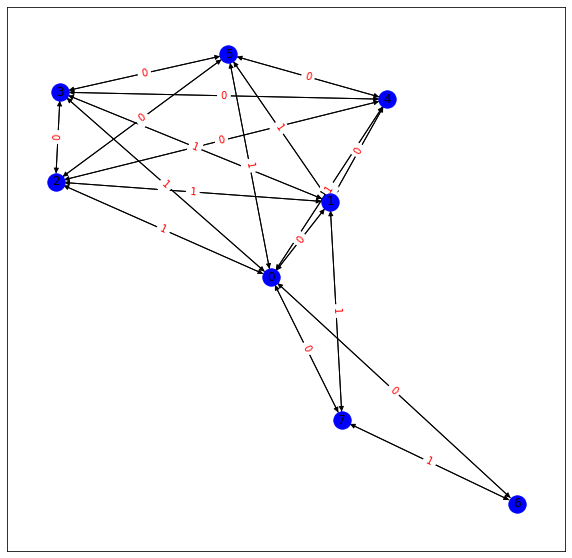

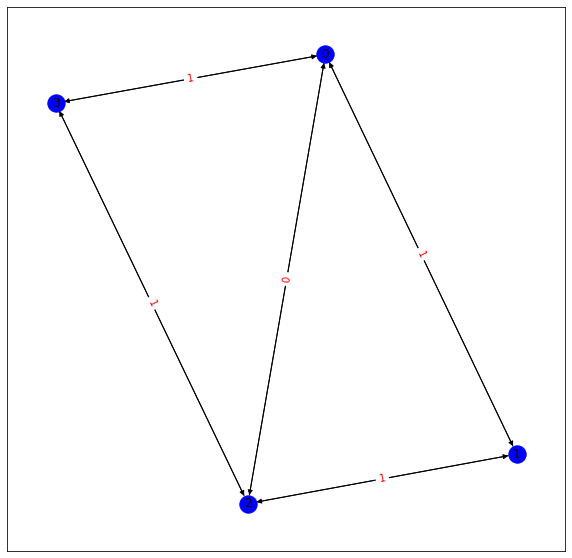

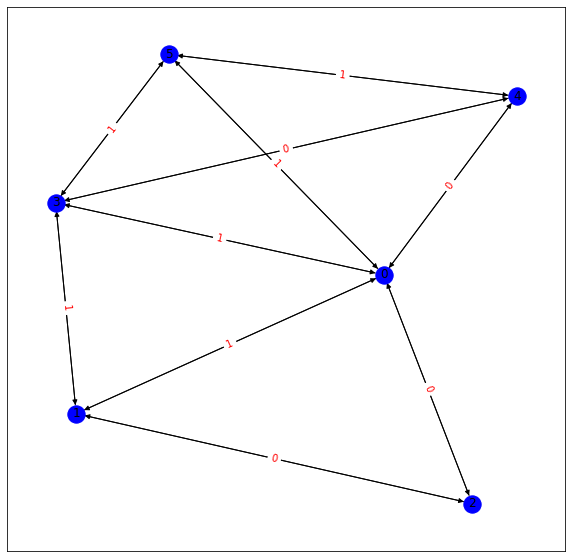

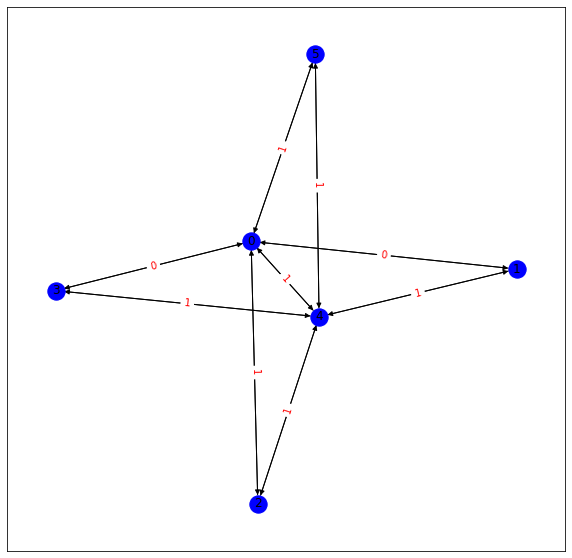

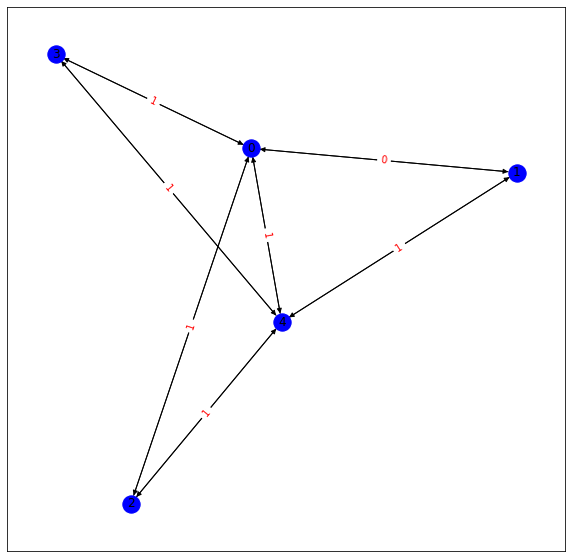

In [51]:
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data, color):
    G = to_networkx(data, to_undirected=False)
    edge_labels = {}
    for i in range(len(G.edges)):
        edge = list(G.edges)[i]
        edge_labels[edge[0], edge[1]] = int(data.edge_type[i])
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G, seed=42), edge_labels=edge_labels, font_color='red')
    plt.show()

for G in dataset[10:15]:
    visualize_graph(G, color="blue")

### Create train and test splits

In [52]:
import random

shuffled_dataset = random.sample(dataset, len(dataset))

train_dataset = shuffled_dataset[:int(len(dataset) * 0.95)]
test_dataset = shuffled_dataset[int(len(dataset) * 0.95):]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 1919
Number of test graphs: 101


### Create the dataloaders

In [53]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# for step, data in enumerate(train_loader):
#     print(f'Step {step + 1}:')
#     print('=======')
#     print(f'Number of graphs in the current batch: {data.num_graphs}')
#     print(data)
#     print()

## Model

### Define the model

In [54]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features = 768, num_classes = 4):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        # 2. Readout layer
        graph_embedding = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(graph_embedding, p=0.5, training=self.training)
        x = self.lin(x)
        return x, graph_embedding

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(768, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=4, bias=True)
)


### Visualizing the embeddings

In [55]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap

def visualize_embeddings(h, color):
    z = umap.UMAP(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

/raid/cs21mtech12001/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


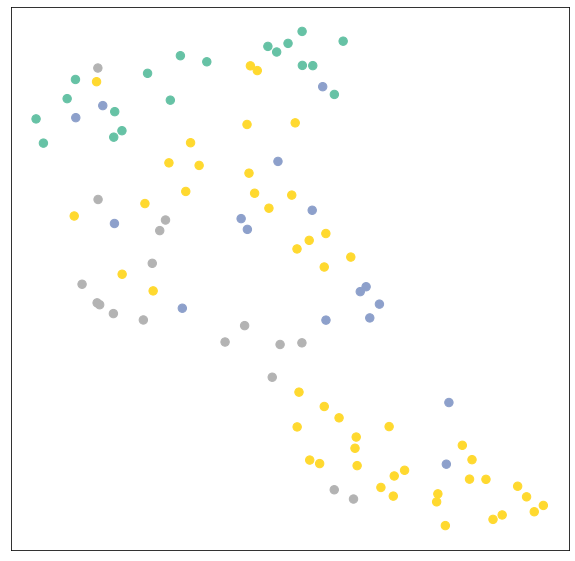

In [56]:
model = GCN(hidden_channels=64)

model.eval()
dataloader = DataLoader(test_dataset, len(test_dataset), shuffle=True)
for data in dataloader:
    out, graph_embedding = model(data.x, data.edge_index, data.batch)
    visualize_embeddings(graph_embedding, color=data.y)

## Training & Testing

In [58]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
         out, _ = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         #print("Out = {} and Label = {}".format(out, data.y))
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.
         total_loss += float(loss)
    print("Loss: ", total_loss)

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out, _ = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(0, 5):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Loss:  124.19804057478905
Epoch: 000, Train Acc: 0.6582, Test Acc: 0.6337
Loss:  77.18838885426521
Epoch: 001, Train Acc: 0.6634, Test Acc: 0.6436
Loss:  73.66058214008808
Epoch: 002, Train Acc: 0.6665, Test Acc: 0.6436
Loss:  76.53483502566814
Epoch: 003, Train Acc: 0.6717, Test Acc: 0.6535
Loss:  76.40749278664589
Epoch: 004, Train Acc: 0.6717, Test Acc: 0.6535


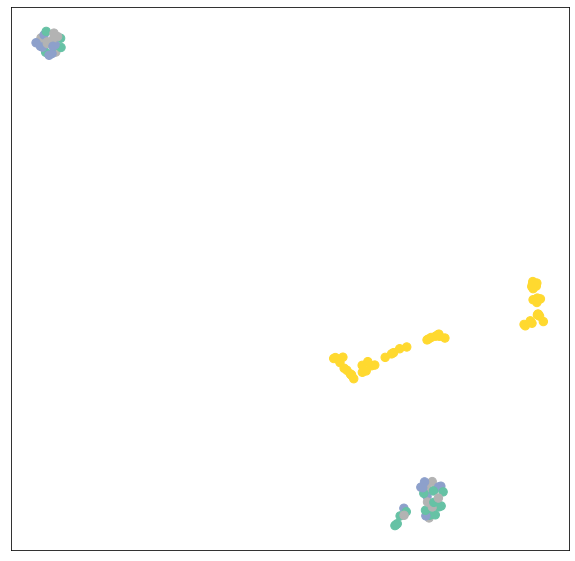

In [59]:
for data in DataLoader(test_dataset, len(test_dataset), shuffle=True):
    out, graph_embedding = model(data.x, data.edge_index, data.batch)
    visualize_embeddings(graph_embedding, color=data.y)

## Cluster the embeddings

### Collect embeddings for a specific class or API

In [76]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

CLASS_LABEL = 2

model.eval()
api_embeddings = []
for data in DataLoader(test_dataset, len(test_dataset), shuffle=False):
    _, graph_embedding = model(data.x, data.edge_index, data.batch)
    for i in range(len(test_dataset)):
        if(int(data[i].y) == CLASS_LABEL):
            api_embeddings.append(graph_embedding[i].detach().cpu().numpy())
print(len(api_embeddings), api_embeddings[0])

49 [ 0.864607    0.11502868  0.74387217 -0.4195376   0.14696264  0.4813913
 -1.1644157  -0.31557345  0.12633589 -0.94453764  0.39957893 -0.73692095
  0.6356601  -0.79161036  0.92876196  1.0051415  -0.06066842  0.65282685
  0.00613609  0.7997661  -0.02303683  0.56955826 -0.83686244  1.4578283
 -0.5752717   0.5647659  -0.18369253  1.0696632   0.661903   -0.8060657
 -0.07259452 -0.9142155  -1.087177   -1.1206799   0.2730626  -1.4346918
 -0.17816585  0.8742844   0.2518636  -0.01409451  0.4369429   0.3357176
  0.21904783 -0.312926    0.09067842 -0.17457983 -0.08708595  0.668035
 -0.8487328   0.15226513  0.30739212  0.5165291   0.7952231   0.94366115
 -0.7684806  -0.8771217   0.81403583  0.5367725   0.6524397  -0.96208644
 -0.08443397 -0.49914706  0.5592463  -0.09353047]


#### K-Means

##### Get optimal clusters number

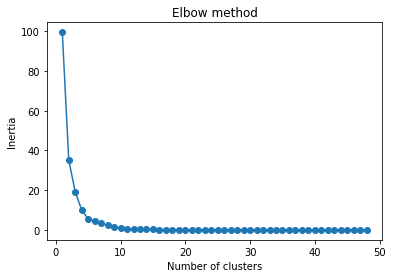

In [77]:
inertias = []

for i in range(1, len(api_embeddings)):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(api_embeddings)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, len(api_embeddings)), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

##### Do clustering

In [82]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(api_embeddings)
kmeans.labels_

array([2, 4, 8, 2, 6, 1, 8, 9, 5, 2, 1, 0, 3, 4, 7, 1, 7, 5, 3, 5, 2, 8,
       7, 0, 2, 1, 3, 3, 3, 3, 3, 1, 0, 1, 1, 0, 5, 3, 1, 0, 7, 1, 1, 2,
       4, 2, 2, 7, 2], dtype=int32)